### 練習

### ファイルの読込

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split

# 追加
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import numpy as np #本書ではあまり紹介していないnumpyライブラリ

%matplotlib inline

df=pd.read_csv("../datafiles/Bank.csv")


### データの前処理１（標準化以外）

#### ダミー変数化

In [18]:
#調査
# print(df)

#文字列項目の検出
is_str = list()
for c in df.columns:
    # type(df[c].head[10])
    for v in df[c].head(10):
      if type(v) != int and type(v) != float:
          is_str.append(c)
          break
str_col_name=is_str
str_df = df[str_col_name]

#ダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

#数値列との結合
num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)


### データを訓練＆検証とテストの２つに分割

In [19]:
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
train_val.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,marital,education,default,housing,loan,contact,month
13378,13379,46,0.0,10,378.293875,1,0,1,False,False,...,False,False,unemployed,married,tertiary,no,yes,no,cellular,jul
3800,3801,41,-333.0,30,300.845752,3,2,0,True,False,...,False,False,blue-collar,divorced,secondary,no,yes,no,cellular,jan
10398,10399,30,5389.0,6,159.053623,3,0,1,False,False,...,False,False,management,single,tertiary,no,no,no,cellular,aug
23401,23402,39,255.0,5,334.802583,1,0,0,False,False,...,False,False,management,single,tertiary,no,yes,no,sending _document,may
26223,26224,47,33.0,5,NaN,1,0,1,False,False,...,False,False,services,single,secondary,no,yes,no,cellular,may


### 欠損値の補正

<Axes: >

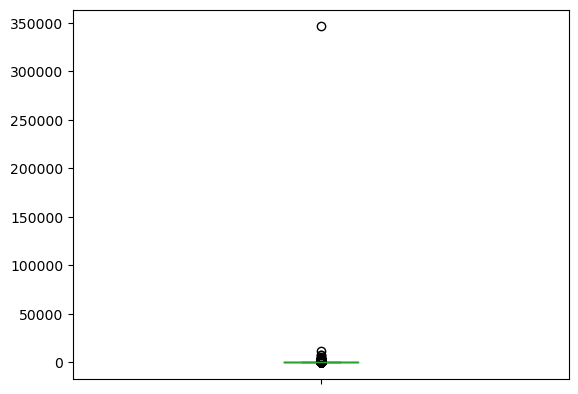

In [20]:
from sklearn.covariance import MinCovDet

#文字の入った列や欠損値のある行をdrop
num_df=train_val.drop(str_col_name,axis=1) #文字の列を取っ払う
num_df=num_df.drop('id',axis=1) #id列を取っ払う
num_df2=num_df.dropna() #欠損列を取っ払う

###欠損値の補正には外れ値は邪魔なので取り除く

#マハラノビス距離を算出し外れ値を検出する
mcd2 =MinCovDet(random_state=0,support_fraction=0.7)
mcd2.fit(num_df2)
dis =mcd2.mahalanobis(num_df2)
dis=pd.Series(dis)
dis.plot(kind="box")


In [21]:
#外れ値のあるインデックスを確認してその行・列を指定してdrop
no=dis[dis>300000].index
# print(no)
no=num_df2.iloc[no[0]:(no[0]+1),:].index
train_val2 = train_val.drop(no)

### 欠損行を削除
# print(train_val2.tail(3))
not_nan_df = train_val2.dropna() #外れ値が無いデータから欠損値をdrop
# print(not_nan_df.tail(3))


In [22]:
#データの関連性の調査
#試しにjob
# print(not_nan_df.columns)
name='job'
cnt =not_nan_df.groupby(name)['y'].value_counts()
df_ = pd.DataFrame(cnt)
print("sum:",df_.sum())
print("----")
print(df_.index[0],df_.iloc[1]/(df_.iloc[0]+df_.iloc[1]))
print("----")
df_

# temp_x = not_nan_df.drop(str_col_name,axis=1) #教師データから文字の列をdrop


sum: count    18083
dtype: int64
----
('admin.', 0) count    0.33018
dtype: float64
----


count
job           y       
admin.        0   1416
              1    698
blue-collar   0   2799
              1   1476
entrepreneur  0    382
              1    258
housemaid     0    319
              1    174
management    0   2211
              1   1336
retired       0    666
              1    367
self-employed 0    359
              1    222
services      0   1155
              1    624
student       0    137
              1     81
technician    0   1836
              1   1017
unemployed    0    311
              1    139
unknown       0     57
              1     43

In [23]:
#データの関連性の調査
#試しにduration
# print(not_nan_df.columns)
name='duration'
cnt =not_nan_df.groupby(name)['y'].value_counts()
df_ = pd.DataFrame(cnt)
print("sum:",df_.sum())
print("----")
print(df_.index[0],df_.iloc[1]/(df_.iloc[0]+df_.iloc[1]))
print("----")
df_

# temp_x = not_nan_df.drop(str_col_name,axis=1) #教師データから文字の列をdrop


sum: count    18083
dtype: int64
----
(19.038719443648237, 0) count    0.5
dtype: float64
----


,,count
duration,y,
19.038719,0,1
34.009388,0,1
46.910033,0,1
50.514705,0,1
52.774810,0,1
...,...,...
608.230566,1,1
610.989820,1,1
612.402981,1,1


In [24]:
#他のデータとの関連性
for name in not_nan_df.columns:
    print(not_nan_df.groupby(name)['y'].mean().tail(3))
    print("next=========")


print(not_nan_df.groupby("duration")['y'].mean().tail(3))

id
27126    0.0
27127    1.0
27128    0.0
Name: y, dtype: float64
next=========
age
92    1.0
93    1.0
94    0.0
Name: y, dtype: float64
next=========
amount
64343.0     0.0
66721.0     0.0
102127.0    0.0
Name: y, dtype: float64
next=========
day
29    0.361823
30    0.435484
31    0.422131
Name: y, dtype: float64
next=========
duration
612.402981    1.0
615.048733    1.0
632.388923    1.0
Name: y, dtype: float64
next=========
campaign
55    0.0
58    0.0
63    0.0
Name: y, dtype: float64
next=========
previous
40    1.0
41    1.0
51    1.0
Name: y, dtype: float64
next=========
y
0    0.0
1    1.0
Name: y, dtype: float64
next=========
job_blue-collar
False    0.359140
True     0.345263
Name: y, dtype: float64
next=========
job_entrepreneur
False    0.354125
True     0.403125
Name: y, dtype: float64
next=========
job_housemaid
False    0.355941
True     0.352941
Name: y, dtype: float64
next=========
job_management
False    0.350784
True     0.376656
Name: y, dtype: float64
next=======

In [25]:
#正解データの抽出
temp_t =not_nan_df[['duration']] #正解データ

#教師データの抽出
temp_x = not_nan_df.drop(str_col_name,axis=1)

#durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y','duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

#推定の検証
a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
#今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1,42):
    val = i/20
    model_liner = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a,c)
    if maxvalue < model_liner.score(b,d):
        v=val #決定係数が最大になるalpha値
        maxvalue = model_liner.score(b,d) #決定係数の最大値
print(v,maxvalue)
model_liner = Lasso(random_state=0,alpha=v)
#今回は予測させたいだけなので、標準化はしない
model_liner.fit(a,c)
#pd.Series(model_liner)


0.15 0.7304944118304566


Lasso(alpha=0.15, random_state=0)

In [26]:
#実際の欠損値の補正対象は外れ値込みのデータ（train_val）
train_val3 = train_val.copy()
is_null=train_val3['duration'].isnull()
temp_x = train_val3.drop(str_col_name,axis=1)
temp_x = temp_x.drop(['y','duration','id'],axis=1)
temp_x = temp_x[is_null]
#non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner.predict(temp_x)
train_val3.loc[is_null,'duration']=pred_d

### アンダーサンプリング

In [27]:
#12章付録で紹介したアンダーサンプリングを行いy=0or1のデータ数を揃える
def under_sampling(train_val):
    y_0=train_val[train_val['y']==0]
    y_1=train_val[train_val['y']==1]
    num_1 = len(y_1)
    #Y=1と同じ件数だけサンプリング
    y_0_2 =y_0.sample(n=num_1,random_state=0)
    ret_train_val = pd.concat([y_1,y_0_2])
    return ret_train_val
    # train_val2 = pd.concat([y_1,y_0_2])
    # return train_val2


### モデルの作成

In [28]:
#学習をさせよう。ただし、13章で学習した知識を使いたい。これまでは正解率を考えてきたが、今回のケースだと適合率
#再現率のどちらを見るべきだろうか？

# y=1の適合率が高い⇒無駄なアポイントメントを減らす事が出来る。
# y=1の再現率が高い⇒潜在顧客を見逃さない

#スッキリ銀行は、効率よくキャンペーンを回したいと考えているので、y=1適合率に着目する


In [29]:
#まず、さくっと学習できるようなlearn関数を定義する。ただし、正解率では無くて適合率をみる
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    base = DecisionTreeClassifier(max_depth=i,random_state=0,class_weight="balanced")
    #model = AdaBoostClassifier(n_estimators=150,base_estimator=base,random_state=0)
    
    #　追加
    
    base.fit(x_train,y_train)
    train_pred = base.predict(x_train)
    test_pred = base.predict(x_val)
    result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    return result,base,datas

t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
res,model,datas = learn(x,t,i=8)
res_df=pd.DataFrame(res)
res_df
#res_df.iloc[0,1]


,0,1,accuracy,macro avg,weighted avg
precision,0.909322,0.587959,0.769404,0.748640,0.810603
recall,0.741058,0.833333,0.769404,0.787196,0.769404
f1-score,0.816612,0.689465,0.769404,0.753039,0.777554
support,3383.000000,1500.000000,0.769404,4883.000000,4883.000000


In [ ]:
# 0	1	accuracy	macro avg	weighted avg
# precision	0.909322	0.587959	0.769404	0.748640	0.810603
# recall	0.741058	0.833333	0.769404	0.787196	0.769404
# f1-score	0.816612	0.689465	0.769404	0.753039	0.777554
# support	3383.000000	1500.000000	0.769404	4883.000000	4883.000000